<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [78]:
!pip install catboost
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [16]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')

In [17]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# **Анализ**

In [19]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [21]:
data_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [22]:
data_train.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [23]:
data_test.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
dtype: object

In [25]:
data_test['TotalSpent'] = pd.to_numeric(data_test['TotalSpent'], errors='coerce')
data_train['TotalSpent'] = pd.to_numeric(data_train['TotalSpent'], errors='coerce')
test_cat_features = cat_cols.copy()
cat_cols.append(target_col)
train_cat_features = cat_cols

In [26]:
print(train_cat_features)

['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn']


In [27]:
data_train[train_cat_features] = data_train[train_cat_features].astype('category')
data_test[test_cat_features] = data_test[test_cat_features].astype('category')
data_test.dtypes

ClientPeriod                   int64
MonthlySpending              float64
TotalSpent                   float64
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
dtype: object

In [28]:
data_train.dtypes

ClientPeriod                   int64
MonthlySpending              float64
TotalSpent                   float64
Sex                         category
IsSeniorCitizen             category
HasPartner                  category
HasChild                    category
HasPhoneService             category
HasMultiplePhoneNumbers     category
HasInternetService          category
HasOnlineSecurityService    category
HasOnlineBackup             category
HasDeviceProtection         category
HasTechSupportAccess        category
HasOnlineTV                 category
HasMovieSubscription        category
HasContractPhone            category
IsBillingPaperless          category
PaymentMethod               category
Churn                       category
dtype: object

# **Удаление**

In [29]:
data_train.isna().mean().sort_values(ascending=False)

TotalSpent                  0.001704
ClientPeriod                0.000000
HasOnlineBackup             0.000000
PaymentMethod               0.000000
IsBillingPaperless          0.000000
HasContractPhone            0.000000
HasMovieSubscription        0.000000
HasOnlineTV                 0.000000
HasTechSupportAccess        0.000000
HasDeviceProtection         0.000000
HasOnlineSecurityService    0.000000
MonthlySpending             0.000000
HasInternetService          0.000000
HasMultiplePhoneNumbers     0.000000
HasPhoneService             0.000000
HasChild                    0.000000
HasPartner                  0.000000
IsSeniorCitizen             0.000000
Sex                         0.000000
Churn                       0.000000
dtype: float64

In [30]:
data_test.isna().mean().sort_values(ascending=False)

TotalSpent                  0.001136
ClientPeriod                0.000000
HasOnlineSecurityService    0.000000
IsBillingPaperless          0.000000
HasContractPhone            0.000000
HasMovieSubscription        0.000000
HasOnlineTV                 0.000000
HasTechSupportAccess        0.000000
HasDeviceProtection         0.000000
HasOnlineBackup             0.000000
HasInternetService          0.000000
MonthlySpending             0.000000
HasMultiplePhoneNumbers     0.000000
HasPhoneService             0.000000
HasChild                    0.000000
HasPartner                  0.000000
IsSeniorCitizen             0.000000
Sex                         0.000000
PaymentMethod               0.000000
dtype: float64

In [31]:
data_test['TotalSpent'] = data_test.TotalSpent.fillna(0)
print(pd.isnull(data_test.TotalSpent))

0       False
1       False
2       False
3       False
4       False
        ...  
1756    False
1757    False
1758    False
1759    False
1760    False
Name: TotalSpent, Length: 1761, dtype: bool


In [32]:
data_train['TotalSpent'] = data_train.TotalSpent.fillna(0)
print(pd.isnull(data_train.TotalSpent))

0       False
1       False
2       False
3       False
4       False
        ...  
5277    False
5278    False
5279    False
5280    False
5281    False
Name: TotalSpent, Length: 5282, dtype: bool


In [33]:
data_train = data_train.dropna()
data_test = data_test.dropna()

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

# **Численные данные**

(array([1205.,  565.,  425.,  423.,  388.,  362.,  340.,  364.,  377.,
         833.]),
 array([ 0. ,  7.2, 14.4, 21.6, 28.8, 36. , 43.2, 50.4, 57.6, 64.8, 72. ]),
 <a list of 10 Patch objects>)

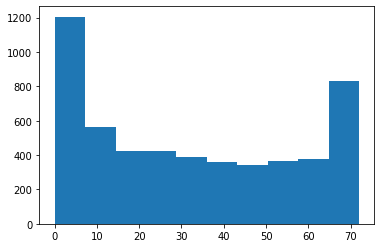

In [40]:
plt.hist(data_train[num_cols[0]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f84820f54c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f84820f5b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f84820f5160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f84820fe280>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f84820fe580>],
 'means': []}

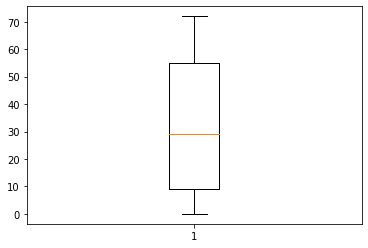

In [39]:
plt.boxplot(data_train[num_cols[0]])

(array([1207.,  142.,  267.,  479.,  350.,  663.,  713.,  659.,  573.,
         229.]),
 array([ 18.25,  28.3 ,  38.35,  48.4 ,  58.45,  68.5 ,  78.55,  88.6 ,
         98.65, 108.7 , 118.75]),
 <a list of 10 Patch objects>)

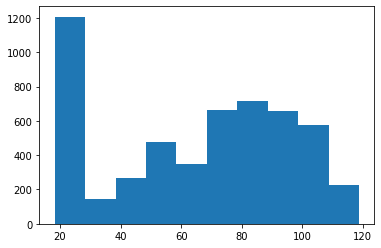

In [36]:
plt.hist(data_train[num_cols[1]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f848204a520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f848204abe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f848204a1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f84820542e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f84820545e0>],
 'means': []}

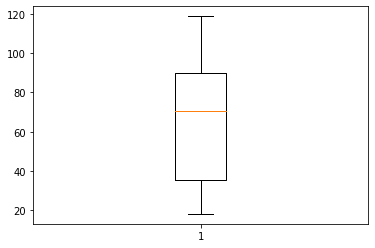

In [41]:
plt.boxplot(data_train[num_cols[1]])

(array([2030.,  900.,  513.,  389.,  347.,  311.,  304.,  223.,  173.,
          92.]),
 array([   0.  ,  868.48, 1736.96, 2605.44, 3473.92, 4342.4 , 5210.88,
        6079.36, 6947.84, 7816.32, 8684.8 ]),
 <a list of 10 Patch objects>)

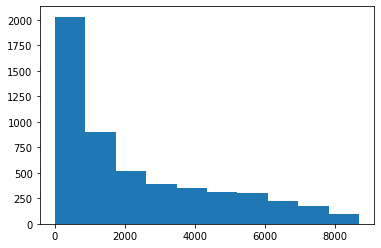

In [42]:
plt.hist(data_train[num_cols[2]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8481f993a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8481f99a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8481f99040>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8481f25160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8481f25460>],
 'means': []}

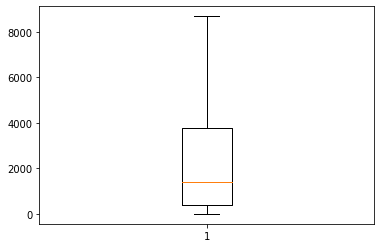

In [43]:
plt.boxplot(data_train[num_cols[2]])

# **Категориальные признаки**

In [49]:
for cat in train_cat_features:
  print(cat, data_train[cat].value_counts(),'\n', sep='\n')

Sex
Male      2655
Female    2627
Name: Sex, dtype: int64


IsSeniorCitizen
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64


HasPartner
No     2705
Yes    2577
Name: HasPartner, dtype: int64


HasChild
No     3676
Yes    1606
Name: HasChild, dtype: int64


HasPhoneService
Yes    4761
No      521
Name: HasPhoneService, dtype: int64


HasMultiplePhoneNumbers
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64


HasDeviceProtection
No                     2317
Yes                    1824
No internet service  

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [50]:
fig, axs = plt.subplots(1, len(cat_cols))
for i in range(len(train_cat_features)):
    print(data_train[train_cat_features[i]].value_counts())
    axs[i].pie(data_train[cat_cols[i]].value_counts(), radius=1)

Male      2655
Female    2627
Name: Sex, dtype: int64
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64
No     2705
Yes    2577
Name: HasPartner, dtype: int64
No     3676
Yes    1606
Name: HasChild, dtype: int64
Yes    4761
No      521
Name: HasPhoneService, dtype: int64
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64
No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64
No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: int64
No    

([<matplotlib.patches.Wedge at 0x7f8429ea03a0>,
 [Text(-0.7478930722742168, 0.8066324766857789, ''),
  Text(0.7478930722742166, -0.8066324766857789, '')])

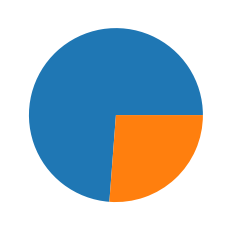

In [51]:
plt.pie(data_train[target_col].value_counts(), radius=1)

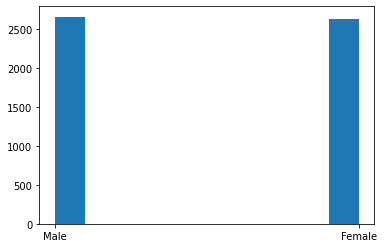

Sex


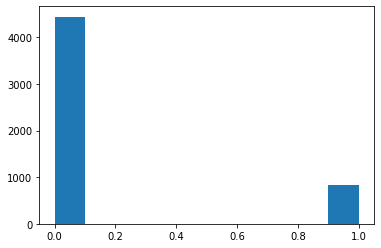

IsSeniorCitizen


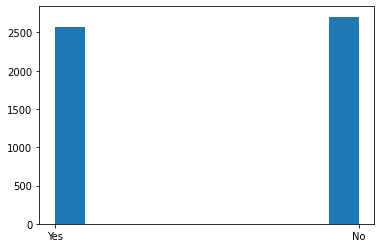

HasPartner


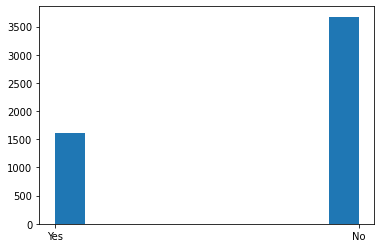

HasChild


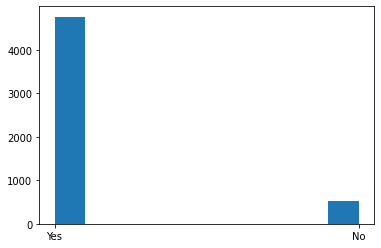

HasPhoneService


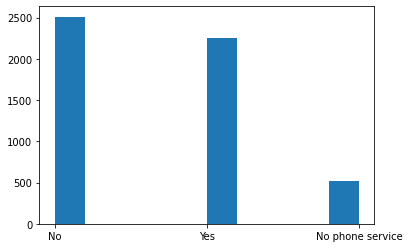

HasMultiplePhoneNumbers


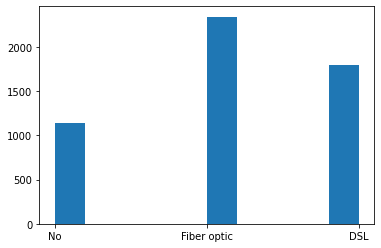

HasInternetService


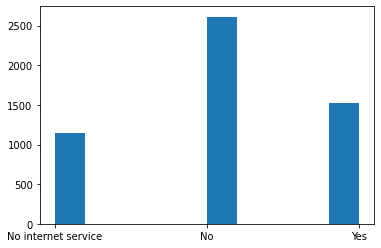

HasOnlineSecurityService


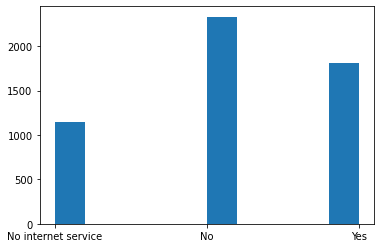

HasOnlineBackup


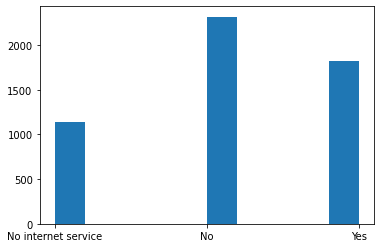

HasDeviceProtection


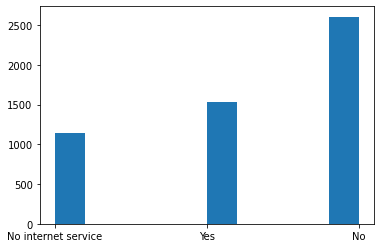

HasTechSupportAccess


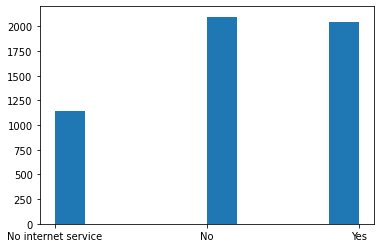

HasOnlineTV


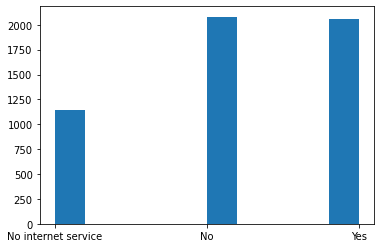

HasMovieSubscription


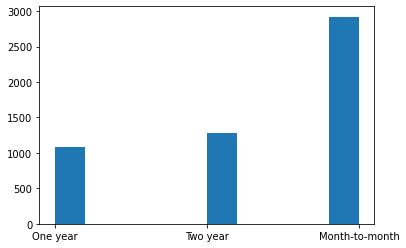

HasContractPhone


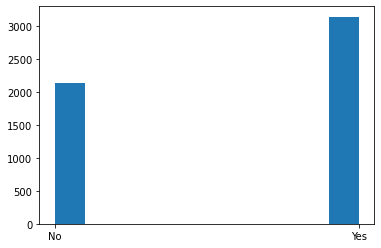

IsBillingPaperless


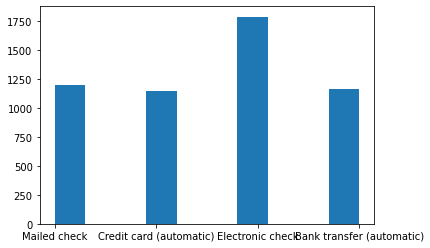

PaymentMethod


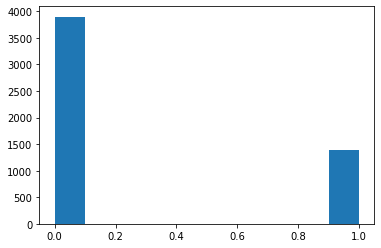

Churn


In [52]:
for i in range(len(train_cat_features)):
    plt.hist(data_train[train_cat_features[i]])
    plt.show()
    print(train_cat_features[i])

Классы несбалансированны!

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

# **Нурмировка**

In [53]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [54]:
data_cat = data_train.drop(columns=['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Churn'])
data_test_cat = data_test.drop(columns=['ClientPeriod', 'MonthlySpending', 'TotalSpent'])
data_cat.head()

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [55]:
train_small_with_dummies = pd.get_dummies(data_cat, sparse=True)
test_small_with_dummies = pd.get_dummies(data_test_cat, sparse=True)
train_small_with_dummies.head(100)

,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,1,0,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
4,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,1,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1
96,1,0,1,0,1,0,0,1,0,1,...,1,0,1,0,0,1,1,0,0,0
97,0,1,1,0,1,0,1,0,0,1,...,1,1,0,0,0,1,0,0,1,0
98,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,0,1,1,0,0,0


In [56]:
data_num = data_train[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]
data_test_num = data_test[['ClientPeriod', 'MonthlySpending', 'TotalSpent']]
data_num.head(100)

,ClientPeriod,MonthlySpending,TotalSpent
0,55,19.50,1026.35
1,72,25.85,1872.20
2,1,75.90,75.90
3,32,79.30,2570.00
4,60,115.25,6758.45
...,...,...,...
95,10,29.60,299.05
96,67,106.60,7244.70
97,52,85.35,4338.60
98,72,108.30,7679.65


In [57]:
normalized_data_num = (data_num-data_num.min())/(data_num.max()-data_num.min())
normalized_data_test_num = (data_test_num-data_test_num.min())/(data_test_num.max()-data_test_num.min())
normalized_data_num.head(100)

,ClientPeriod,MonthlySpending,TotalSpent
0,0.763889,0.012438,0.118178
1,1.000000,0.075622,0.215572
2,0.013889,0.573632,0.008739
3,0.444444,0.607463,0.295919
4,0.833333,0.965174,0.778193
...,...,...,...
95,0.138889,0.112935,0.034434
96,0.930556,0.879104,0.834182
97,0.722222,0.667662,0.499562
98,1.000000,0.896020,0.884263


In [58]:
X = pd.concat([train_small_with_dummies, normalized_data_num], axis=1)
X_test = pd.concat([test_small_with_dummies, normalized_data_test_num], axis=1)
X.head(100)

,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,ClientPeriod,MonthlySpending,TotalSpent
0,0,1,1,0,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0.763889,0.012438,0.118178
1,0,1,1,0,0,1,1,0,0,1,...,1,1,0,0,1,0,0,1.000000,0.075622,0.215572
2,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0.013889,0.573632,0.008739
3,1,0,0,1,0,1,1,0,0,1,...,0,1,0,0,0,0,1,0.444444,0.607463,0.295919
4,1,0,1,0,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0.833333,0.965174,0.778193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,1,0,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0.138889,0.112935,0.034434
96,1,0,1,0,1,0,0,1,0,1,...,0,0,1,1,0,0,0,0.930556,0.879104,0.834182
97,0,1,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0.722222,0.667662,0.499562
98,1,0,1,0,0,1,0,1,0,1,...,1,0,1,1,0,0,0,1.000000,0.896020,0.884263


In [59]:
len(X_test)

1761

In [60]:
y = data_train['Churn']
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: category
Categories (2, int64): [0, 1]

# **Применение линейной регрессии**

In [65]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [66]:
clf = LogisticRegressionCV(cv=5, random_state=42, scoring='roc_auc', n_jobs=-1, refit=True).fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [67]:
clf.predict(X)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0, 0, 1, ..., 0, 0, 0])

In [68]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5277    0
5278    0
5279    0
5280    0
5281    0
Name: Churn, Length: 5282, dtype: category
Categories (2, int64): [0, 1]

In [70]:
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/uti

[0.86228825 0.83692956 0.83457358 0.8561008  0.83573312]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# **[0.86228825 0.83692956 0.83457358 0.8561008  0.83573312]**

In [73]:
print(scores.mean())

0.8451250628424853


# **0.8451250628424853**

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [103]:
train, test = train_test_split(data_train,train_size=0.6,random_state=42,stratify=data_train['Churn'])
val, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['Churn'])
y = ['Churn']

In [98]:
from catboost.core import Pool
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=test_cat_features
                  )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=test_cat_features
                  )

In [105]:
params = {'verbose':100,
          'random_seed':42,
          'eval_metric':'AUC',
          'learning_rate':0.09}

In [106]:
from catboost import CatBoostClassifier

In [107]:
model_cat_default = CatBoostClassifier(**params)

In [108]:
model_cat_default.fit(train_data,eval_set=valid_data)

0:	test: 0.7926945	best: 0.7926945 (0)	total: 64.8ms	remaining: 1m 4s
100:	test: 0.8487138	best: 0.8491540 (98)	total: 1.37s	remaining: 12.2s
200:	test: 0.8403025	best: 0.8491540 (98)	total: 2.79s	remaining: 11.1s
300:	test: 0.8386991	best: 0.8491540 (98)	total: 4.23s	remaining: 9.82s
400:	test: 0.8349615	best: 0.8491540 (98)	total: 5.72s	remaining: 8.55s
500:	test: 0.8329919	best: 0.8491540 (98)	total: 7.2s	remaining: 7.17s
600:	test: 0.8307165	best: 0.8491540 (98)	total: 8.69s	remaining: 5.77s
700:	test: 0.8270462	best: 0.8491540 (98)	total: 10.2s	remaining: 4.37s
800:	test: 0.8256188	best: 0.8491540 (98)	total: 11.7s	remaining: 2.91s
900:	test: 0.8246919	best: 0.8491540 (98)	total: 13.2s	remaining: 1.45s
999:	test: 0.8235704	best: 0.8491540 (98)	total: 16.1s	remaining: 0us

bestTest = 0.8491540112
bestIteration = 98

Shrink model to first 99 iterations.


In [109]:
test['churn_cat_default'] = model_cat_default.predict_proba(test[X])[:,1]
test_score = roc_auc_score(test['Churn'], test['churn_cat_default'])
print(test_score)

0.8501828195871518


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [110]:
best_model = model_cat_default # какая-то предыдущая модель

In [112]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)
submission = pd.read_csv('./my_submission.csv')
print(submission)

        Id     Churn
0        0  0.038311
1        1  0.659236
2        2  0.618548
3        3  0.016789
4        4  0.005385
...    ...       ...
1756  1756  0.202034
1757  1757  0.007453
1758  1758  0.859668
1759  1759  0.569946
1760  1760  0.018542

[1761 rows x 2 columns]


# **bestTest = 0.8491540112**
# **bestIteration = 98**

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.